In [43]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [44]:
EPOCHS = 35
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((100, 100))
image_size = 0
directory_root = r'C:\Users\80965\Downloads\disease_dataset'
width=100
height=100
depth=3

In [45]:
import os

os.path.exists(directory_root)

True

In [46]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [47]:
directory_root

'C:\\Users\\80965\\Downloads\\disease_dataset'

In [48]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:250]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Image loading completed


In [49]:
image_size = len(image_list)

In [50]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform2.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [51]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [52]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [53]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [54]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [55]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 activation_7 (Activation)   (None, 100, 100, 32)      0         
                                                                 
 batch_normalization_6 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 33, 33, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 33, 33, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 33, 33, 64)       

In [57]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


C:\Users\80965\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [58]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

<ipython-input-58-f5a41846f0f2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/35
91/91 [==============================] - 57s 598ms/step - loss: 0.6087 - accuracy: 0.2330 - val_loss: 0.3647 - val_accuracy: 0.0739
Epoch 2/35
91/91 [==============================] - 52s 572ms/step - loss: 0.1949 - accuracy: 0.4863 - val_loss: 0.4379 - val_accuracy: 0.0752
Epoch 3/35
91/91 [==============================] - 51s 559ms/step - loss: 0.1354 - accuracy: 0.6199 - val_loss: 0.5286 - val_accuracy: 0.0780
Epoch 4/35
91/91 [==============================] - 51s 554ms/step - loss: 0.1166 - accuracy: 0.6985 - val_loss: 0.5448 - val_accuracy: 0.1368
Epoch 5/35
91/91 [==============================] - 51s 555ms/step - loss: 0.1035 - accuracy: 0.7459 - val_loss: 0.4357 - val_accuracy: 0.2695
Epoch 6/35
91/91 [==============================] - 52s 573ms/step - loss: 0.1020 - accuracy: 0.7439 - val_loss: 0.2937 - val_accuracy: 0.4118
Epoch 7/35
91/91 [==============================] - 51s 562ms/step - loss: 0.0907 - accuracy: 0.7698 - val_loss: 0.3157 - val_accuracy: 0.4350

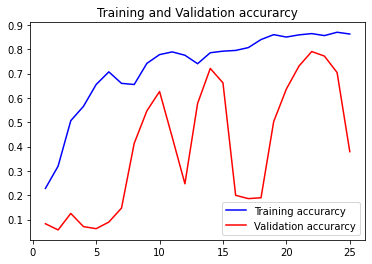

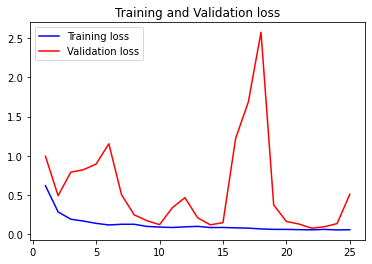

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [59]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
23/23 [==============================] - 2s 85ms/step - loss: 0.0908 - accuracy: 0.8126
Test Accuracy: 81.25854730606079


In [60]:
# Save the model using TensorFlow SavedModel format
model.save('git_model.h5')

In [61]:
scores = model.evaluate(x_train, y_train)
print(f"Test Accuracy: {scores[1]*100}")

92/92 [==============================] - 8s 86ms/step - loss: 0.0848 - accuracy: 0.8295
Test Accuracy: 82.95104503631592


In [137]:
print("[INFO] Saving model...")
model.save("final_model.h5")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...
INFO:tensorflow:Assets written to: ram://5d85a905-0a9f-4247-8d0f-0ba59bbb9cc8/assets


In [36]:
 from keras.models import load_model
model_final = load_model('cnn_model.h5')


In [40]:
image_dir=r"C:\Users\80965\Downloads\PlantVillage\Tomato__Tomato_YellowLeaf__Curl_Virus\96ed7022-a152-4f1d-b934-dca1949159d2___UF.GRC_YLCV_Lab 02183.JPG"
im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

In [41]:
im

array([[[140., 141., 139.],
        [140., 141., 139.],
        [139., 140., 138.],
        ...,
        [128., 128., 128.],
        [127., 127., 127.],
        [126., 126., 126.]],

       [[137., 138., 136.],
        [137., 138., 136.],
        [136., 137., 135.],
        ...,
        [129., 129., 129.],
        [128., 128., 128.],
        [127., 127., 127.]],

       [[134., 135., 133.],
        [134., 135., 133.],
        [134., 135., 133.],
        ...,
        [131., 131., 131.],
        [130., 130., 130.],
        [129., 129., 129.]],

       ...,

       [[122., 120., 119.],
        [123., 121., 120.],
        [125., 123., 122.],
        ...,
        [109., 109., 109.],
        [110., 110., 110.],
        [110., 110., 110.]],

       [[120., 118., 117.],
        [120., 118., 117.],
        [121., 119., 118.],
        ...,
        [106., 106., 106.],
        [108., 108., 108.],
        [109., 109., 109.]],

       [[120., 118., 117.],
        [118., 116., 115.],
        [118., 1

In [38]:
result=model_final.predict(npp_image)

print(result)

[[4.5281073e-08 4.3489132e-07 9.1634735e-09 2.1963360e-06 1.5854572e-07
  4.2083597e-05 1.1488897e-07 2.7807710e-05 1.1452081e-08 7.1909197e-04
  2.8886086e-07 9.8861463e-08 9.9920768e-01 4.9540954e-08 3.5693628e-08]]


In [39]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:0.9992077
Tomato__Tomato_YellowLeaf__Curl_Virus
